In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
from multiprocessing import Pool
from sklearn.model_selection import KFold
import lightgbm as lgb
from optiver_features import ffill

## Generate 5m dataset

In [3]:
data_dir = Path('../input/optiver-realized-volatility-prediction')

In [4]:
# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

def book_preprocessor(df, stock_id):
    #df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    #df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
    #df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
    #df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)
    
    # Merge all
    #df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    #df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    #df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
    #df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    # Create row_id so we can merge
    #stock_id = str(file_path).split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature = df_feature.rename(columns={"time_id_": "time_id"})
    
    df_feature['stock_id'] = stock_id
    return df_feature

In [5]:
def trade_preprocessor(df, stock_id):
    #df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
#     df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
#     df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
    # Drop unnecesary time_ids
#     df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    #stock_id = str(file_path).split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

In [6]:
def realized_volatility_per_time_id(df_book_data, stock_id):
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':'target'})
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id', 'target']]

In [7]:
def preprocess_one_stock(stock_id, typ='train'):
    book_df = pd.read_parquet(data_dir / f'book_{typ}.parquet/stock_id={stock_id}')
    book_df = ffill(book_df)
    trade_df = pd.read_parquet(data_dir / f'trade_{typ}.parquet/stock_id={stock_id}')
    book_5m  = book_preprocessor(book_df[book_df.seconds_in_bucket < 300].copy(), stock_id)
    trade_5m = trade_preprocessor(trade_df[trade_df.seconds_in_bucket < 300].copy(), stock_id)
    realized_vol = realized_volatility_per_time_id(book_df[book_df.seconds_in_bucket >= 300].copy(), stock_id)
    res = pd.merge(book_5m, trade_5m, on = 'row_id', how = 'left')
    res = pd.merge(res, realized_vol, on = 'row_id', how='left')
    return res

In [8]:
def preprocess_5_to_10(stock_id, typ='train'):
    book_df = pd.read_parquet(data_dir / f'book_{typ}.parquet/stock_id={stock_id}')
    book_df = ffill(book_df)
    trade_df = pd.read_parquet(data_dir / f'trade_{typ}.parquet/stock_id={stock_id}')
    book_5m  = book_preprocessor(book_df[book_df.seconds_in_bucket >=300].copy(), stock_id)
    trade_5m = trade_preprocessor(trade_df[trade_df.seconds_in_bucket >= 300].copy(), stock_id)
    res = pd.merge(book_5m, trade_5m, on = 'row_id', how = 'left')
    return res

In [9]:
def preprocess_all(list_stock_ids, typ='train'):
    pool = Pool(16)
    df = pool.starmap(preprocess_one_stock, zip(list_stock_ids, [typ]*len(list_stock_ids)))
    df = pd.concat(df, ignore_index = True)
    return df


In [10]:
def preprocess_all_5_10(list_stock_ids, typ='train'):
    pool = Pool(16)
    df = pool.starmap(preprocess_5_to_10, zip(list_stock_ids, [typ]*len(list_stock_ids)))
    df = pd.concat(df, ignore_index = True)
    return df


In [11]:
def generate_train_df():
    train_df = pd.read_csv(data_dir/'train.csv')
    train_stock_ids = train_df['stock_id'].unique()
    train_features = preprocess_all(train_stock_ids, 'train')
    return train_features

In [12]:
def generate_5_to_10():
    train_df = pd.read_csv(data_dir/'train.csv')
    train_stock_ids = train_df['stock_id'].unique()
    train_features = preprocess_all_5_10(train_stock_ids, 'train')
    return train_features

In [33]:
train_df = generate_train_df()


# train_df.to_csv('train_5m.df', index=False)

In [14]:
train_df = pd.read_csv('train_5m.df')

In [35]:
train_df.target = train_df.target.replace(0,train_df.target.mean())

In [16]:
len(train_df)

428932

## LGBM Baseline

In [60]:
def rmspe_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe_np(y_true, y_pred), False

def train_models(train):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    models =[]
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 5, random_state = 1111, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 3000, 
                          early_stopping_rounds = 25, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        models.append(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        #test_predictions += model.predict(x_test) / 10
        
    rmspe_score = rmspe_np(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return models

In [16]:
_=train_models(train_df)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000360649	training's RMSPE: 0.247353	valid_1's rmse: 0.000370301	valid_1's RMSPE: 0.253292
[200]	training's rmse: 0.000352139	training's RMSPE: 0.241517	valid_1's rmse: 0.00036751	valid_1's RMSPE: 0.251383
Early stopping, best iteration is:
[208]	training's rmse: 0.000351711	training's RMSPE: 0.241223	valid_1's rmse: 0.000367395	valid_1's RMSPE: 0.251304
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000360059	training's RMSPE: 0.247387	valid_1's rmse: 0.000385922	valid_1's RMSPE: 0.262085
[200]	training's rmse: 0.000352039	training's RMSPE: 0.241877	valid_1's rmse: 0.000382626	valid_1's RMSPE: 0.259846
[300]	training's rmse: 0.0003472	training's RMSPE: 0.238551	valid_1's rmse: 0.000381338	valid_1's RMSPE: 0.258971
Early stopping, best iteration is:
[368]	training's rmse: 0.000344786	training's RMSPE: 0.236893	valid_1's rmse: 0.000380891	valid_1's RMSPE: 0.258668
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000361442	training's RMSPE: 0.245717	valid_1's rmse: 0.000433884	valid_1's RMSPE: 0.307054
Early stopping, best iteration is:
[106]	training's rmse: 0.000360679	training's RMSPE: 0.245198	valid_1's rmse: 0.000433256	valid_1's RMSPE: 0.30661
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000360735	training's RMSPE: 0.247391	valid_1's rmse: 0.000382665	valid_1's RMSPE: 0.261836
[200]	training's rmse: 0.000352754	training's RMSPE: 0.241918	valid_1's rmse: 0.000378777	valid_1's RMSPE: 0.259176
Early stopping, best iteration is:
[225]	training's rmse: 0.000351392	training's RMSPE: 0.240984	valid_1's rmse: 0.000378498	valid_1's RMSPE: 0.258985
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000359133	training's RMSPE: 0.24739	valid_1's rmse: 0.000371712	valid_1's RMSPE: 0.249735
[200]	training's rmse: 0.000351016	training's RMSPE: 0.241799	valid_1's rmse: 0.000367894	valid_1's RMSPE: 0.24717
[300]	training's rmse: 0.000346282	training's RMSPE: 0.238538	valid_1's rmse: 0.000366285	valid_1's RMSPE: 0.246089
[400]	training's rmse: 0.000342881	training's RMSPE: 0.236195	valid_1's rmse: 0.000365247	valid_1's RMSPE: 0.245391
[500]	training's rmse: 0.000340189	training's RMSPE: 0.234341	valid_1's rmse: 0.000364664	valid_1's RMSPE: 0.245
[600]	training's rmse: 0.000337919	training's RMSPE: 0.232777	valid_1's rmse: 0.000364243	valid_1's RMSPE: 0.244717
[700]	training's rmse: 0.000335984	training's RMSPE: 0.231444	valid_1's rmse: 0.000363968	valid_1's RMSPE: 0.244532
Early stopping, best iteration is:
[717]	training's rmse: 0.000335638	training's RMSPE: 0.231206	valid_1's rmse: 0.000363884	valid_1

## Learning embeddings

In [26]:
cont_nn,cat_nn = cont_cat_split(train_df, max_card=9000, dep_var='target')
cat_nn.remove('row_id')

In [27]:
cat_nn

['time_id', 'stock_id']

In [41]:

procs_nn = [Categorify, FillMissing,Normalize]

splits = RandomSplitter()(train_df)

dls = TabularPandas(train_df, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

In [42]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[.5,.2,0], 'embed_p':.25, }
learn = tabular_learner(dls, y_range=(0,.1), layers=[100,50,20], emb_szs={'stock_id':10, 'time_id':10}, 
                        n_out=1, loss_func = rmspe, metrics=AccumMetric(rmspe), config=config)

In [43]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,rmspe,time
0,12.292204,10.023963,10.028076,00:03
1,1.593133,0.701313,1.032341,00:03
2,0.459753,0.339552,0.400446,00:03
3,0.375230,0.285995,0.287980,00:03
4,0.323547,0.257406,0.257879,00:03
5,0.322598,0.251798,0.256070,00:03
6,0.283244,0.256082,0.261079,00:03
7,0.285927,0.244123,0.245920,00:03
8,0.266510,0.239383,0.242188,00:03
9,0.258033,0.242236,0.248476,00:03


In [44]:
torch.save(learn.model.embeds[0].weight.data, 'timeemb10.pt')

In [45]:
categorify = dls.procs[2]
len(categorify.classes['time_id'])

3831

In [85]:
def append_embs(data_df, categorify, time_embs, stock_embs):
    time_id_embs = dict()
    for idx, time_id in enumerate(categorify.classes['time_id']):
        time_id_embs[time_id] = time_embs.weight[idx].tolist()

    stock_id_embs = dict()
    for idx, stock_id in enumerate(categorify.classes['stock_id']):
        stock_id_embs[stock_id] = stock_embs.weight[idx].tolist()

    all_embs = []
    for _, row in (data_df[['stock_id', 'time_id']].iterrows()):
        emb1 = stock_id_embs[row.stock_id]
        emb2 = time_id_embs[row.time_id]
        all_embs.append(emb1+emb2)
    columns = [f'stock_emb{i}' for i in range(stock_embs.weight.shape[1])] +[f'time_emb{i}' for i in range(time_embs.weight.shape[1])]
    embs_df = pd.DataFrame(all_embs, columns=columns)

    return pd.concat([data_df, embs_df], axis=1)

In [88]:
train_with_embs = append_embs(train_df, categorify, learn.model.embeds[0], learn.model.embeds[1])



In [52]:
test_df = generate_5_to_10()
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)
preds5_10 = preds.view(-1).numpy()

## Train 5m LGBM with embeddings


In [28]:
_=train_models(train_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000324031	training's RMSPE: 0.222238	valid_1's rmse: 0.000332081	valid_1's RMSPE: 0.227149
[200]	training's rmse: 0.00031552	training's RMSPE: 0.216401	valid_1's rmse: 0.000327265	valid_1's RMSPE: 0.223854
[300]	training's rmse: 0.000310753	training's RMSPE: 0.213132	valid_1's rmse: 0.000325976	valid_1's RMSPE: 0.222973
Early stopping, best iteration is:
[300]	training's rmse: 0.000310753	training's RMSPE: 0.213132	valid_1's rmse: 0.000325976	valid_1's RMSPE: 0.222973
Training fold 2


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000322768	training's RMSPE: 0.221765	valid_1's rmse: 0.000347521	valid_1's RMSPE: 0.236006
[200]	training's rmse: 0.000314802	training's RMSPE: 0.216292	valid_1's rmse: 0.000342993	valid_1's RMSPE: 0.23293
Early stopping, best iteration is:
[256]	training's rmse: 0.000312153	training's RMSPE: 0.214472	valid_1's rmse: 0.000342132	valid_1's RMSPE: 0.232346
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000325286	training's RMSPE: 0.221138	valid_1's rmse: 0.000347615	valid_1's RMSPE: 0.246003
Early stopping, best iteration is:
[103]	training's rmse: 0.00032496	training's RMSPE: 0.220916	valid_1's rmse: 0.00034736	valid_1's RMSPE: 0.245822
Training fold 4


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000323893	training's RMSPE: 0.222125	valid_1's rmse: 0.000343677	valid_1's RMSPE: 0.235159
[200]	training's rmse: 0.000315516	training's RMSPE: 0.216381	valid_1's rmse: 0.000338029	valid_1's RMSPE: 0.231295
[300]	training's rmse: 0.000310725	training's RMSPE: 0.213095	valid_1's rmse: 0.000334501	valid_1's RMSPE: 0.22888
Early stopping, best iteration is:
[347]	training's rmse: 0.000308923	training's RMSPE: 0.211859	valid_1's rmse: 0.00033413	valid_1's RMSPE: 0.228627
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000322635	training's RMSPE: 0.222249	valid_1's rmse: 0.000336257	valid_1's RMSPE: 0.225914
[200]	training's rmse: 0.000314039	training's RMSPE: 0.216327	valid_1's rmse: 0.000332355	valid_1's RMSPE: 0.223293
[300]	training's rmse: 0.000309389	training's RMSPE: 0.213124	valid_1's rmse: 0.000330444	valid_1's RMSPE: 0.222009
[400]	training's rmse: 0.000306236	training's RMSPE: 0.210952	valid_1's rmse: 0.000329441	valid_1's RMSPE: 0.221335
[500]	training's rmse: 0.000303719	training's RMSPE: 0.209218	valid_1's rmse: 0.000328984	valid_1's RMSPE: 0.221028
[600]	training's rmse: 0.000301583	training's RMSPE: 0.207747	valid_1's rmse: 0.000328692	valid_1's RMSPE: 0.220832
[700]	training's rmse: 0.000299705	training's RMSPE: 0.206453	valid_1's rmse: 0.000328403	valid_1's RMSPE: 0.220638
Early stopping, best iteration is:
[710]	training's rmse: 0.000299511	training's RMSPE: 0.20632	valid_1's rmse: 0.000328358	val

## Baseline LGMB 10m

In [61]:
train_10m = pd.read_csv('train_with_features_NO_ST.csv')

In [62]:
from optiver_features import get_time_stock
train_10m_time_stock = get_time_stock(train_10m)

In [63]:
_=train_models(train_10m_time_stock)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000472369	training's RMSPE: 0.218697	valid_1's rmse: 0.000483167	valid_1's RMSPE: 0.223294
[200]	training's rmse: 0.000456434	training's RMSPE: 0.211319	valid_1's rmse: 0.000471963	valid_1's RMSPE: 0.218117
[300]	training's rmse: 0.000444947	training's RMSPE: 0.206001	valid_1's rmse: 0.000463557	valid_1's RMSPE: 0.214231
[400]	training's rmse: 0.00043609	training's RMSPE: 0.201901	valid_1's rmse: 0.000457713	valid_1's RMSPE: 0.211531
[500]	training's rmse: 0.000428288	training's RMSPE: 0.198288	valid_1's rmse: 0.000452597	valid_1's RMSPE: 0.209167
[600]	training's rmse: 0.000422108	training's RMSPE: 0.195427	valid_1's rmse: 0.000449117	valid_1's RMSPE: 0.207558
[700]	training's rmse: 0.000416375	training's RMSPE: 0.192773	valid_1's rmse: 0.000445402	valid_1's RMSPE: 0.205841
[800]	training's rmse: 0.000410935	training's RMSPE: 0.190254	valid_1's rmse: 0.00044216	valid_1's RMSPE: 0.204343
[900]	trainin

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00047405	training's RMSPE: 0.219247	valid_1's rmse: 0.000493132	valid_1's RMSPE: 0.228847
[200]	training's rmse: 0.000457643	training's RMSPE: 0.211659	valid_1's rmse: 0.000482029	valid_1's RMSPE: 0.223694
[300]	training's rmse: 0.000446028	training's RMSPE: 0.206287	valid_1's rmse: 0.000474004	valid_1's RMSPE: 0.21997
[400]	training's rmse: 0.000437256	training's RMSPE: 0.20223	valid_1's rmse: 0.000468424	valid_1's RMSPE: 0.217381
[500]	training's rmse: 0.000429788	training's RMSPE: 0.198776	valid_1's rmse: 0.000463568	valid_1's RMSPE: 0.215127
Early stopping, best iteration is:
[546]	training's rmse: 0.000426411	training's RMSPE: 0.197214	valid_1's rmse: 0.0004622	valid_1's RMSPE: 0.214492
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000471619	training's RMSPE: 0.21837	valid_1's rmse: 0.000478397	valid_1's RMSPE: 0.221005
[200]	training's rmse: 0.000456622	training's RMSPE: 0.211427	valid_1's rmse: 0.000466537	valid_1's RMSPE: 0.215526
[300]	training's rmse: 0.000445607	training's RMSPE: 0.206327	valid_1's rmse: 0.000458002	valid_1's RMSPE: 0.211583
[400]	training's rmse: 0.000436655	training's RMSPE: 0.202182	valid_1's rmse: 0.000451147	valid_1's RMSPE: 0.208416
[500]	training's rmse: 0.000429267	training's RMSPE: 0.198761	valid_1's rmse: 0.000445774	valid_1's RMSPE: 0.205934
[600]	training's rmse: 0.000422695	training's RMSPE: 0.195718	valid_1's rmse: 0.000441604	valid_1's RMSPE: 0.204008
[700]	training's rmse: 0.00041678	training's RMSPE: 0.192979	valid_1's rmse: 0.000438011	valid_1's RMSPE: 0.202348
[800]	training's rmse: 0.000411842	training's RMSPE: 0.190692	valid_1's rmse: 0.000434914	valid_1's RMSPE: 0.200917
[900]	trainin

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000473051	training's RMSPE: 0.218659	valid_1's rmse: 0.000479689	valid_1's RMSPE: 0.223117
[200]	training's rmse: 0.000457686	training's RMSPE: 0.211557	valid_1's rmse: 0.000469326	valid_1's RMSPE: 0.218297
[300]	training's rmse: 0.000445643	training's RMSPE: 0.20599	valid_1's rmse: 0.000460368	valid_1's RMSPE: 0.214131
[400]	training's rmse: 0.000436376	training's RMSPE: 0.201707	valid_1's rmse: 0.000453278	valid_1's RMSPE: 0.210833
[500]	training's rmse: 0.000428336	training's RMSPE: 0.197991	valid_1's rmse: 0.0004482	valid_1's RMSPE: 0.208471
[600]	training's rmse: 0.000422644	training's RMSPE: 0.19536	valid_1's rmse: 0.000446044	valid_1's RMSPE: 0.207468
[700]	training's rmse: 0.000417281	training's RMSPE: 0.192881	valid_1's rmse: 0.000443371	valid_1's RMSPE: 0.206225
[800]	training's rmse: 0.00041215	training's RMSPE: 0.190509	valid_1's rmse: 0.000440851	valid_1's RMSPE: 0.205053
[900]	training's

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000471791	training's RMSPE: 0.218595	valid_1's rmse: 0.000485867	valid_1's RMSPE: 0.223856
[200]	training's rmse: 0.000456254	training's RMSPE: 0.211397	valid_1's rmse: 0.000472728	valid_1's RMSPE: 0.217803
[300]	training's rmse: 0.000444348	training's RMSPE: 0.20588	valid_1's rmse: 0.000463477	valid_1's RMSPE: 0.213541
[400]	training's rmse: 0.00043573	training's RMSPE: 0.201887	valid_1's rmse: 0.000457275	valid_1's RMSPE: 0.210683
[500]	training's rmse: 0.000428962	training's RMSPE: 0.198751	valid_1's rmse: 0.000453733	valid_1's RMSPE: 0.209051
[600]	training's rmse: 0.000422235	training's RMSPE: 0.195634	valid_1's rmse: 0.000448767	valid_1's RMSPE: 0.206763
[700]	training's rmse: 0.000416327	training's RMSPE: 0.192897	valid_1's rmse: 0.000445273	valid_1's RMSPE: 0.205153
[800]	training's rmse: 0.000411091	training's RMSPE: 0.190471	valid_1's rmse: 0.000442164	valid_1's RMSPE: 0.203721
[900]	trainin

## LGBM 10m with trained embeddings

In [64]:
train_10m = pd.read_csv('train_with_features_NO_ST.csv')

In [89]:
train_10m_with_embs = append_embs(train_10m, categorify, learn.model.embeds[0], learn.model.embeds[1])

In [90]:
_=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000479529	training's RMSPE: 0.222012	valid_1's rmse: 0.000489676	valid_1's RMSPE: 0.226303
[200]	training's rmse: 0.000467705	training's RMSPE: 0.216538	valid_1's rmse: 0.00048135	valid_1's RMSPE: 0.222455
[300]	training's rmse: 0.00045937	training's RMSPE: 0.212679	valid_1's rmse: 0.000475573	valid_1's RMSPE: 0.219785
[400]	training's rmse: 0.000452458	training's RMSPE: 0.209479	valid_1's rmse: 0.000471505	valid_1's RMSPE: 0.217905
[500]	training's rmse: 0.00044617	training's RMSPE: 0.206567	valid_1's rmse: 0.00046753	valid_1's RMSPE: 0.216068
[600]	training's rmse: 0.000440645	training's RMSPE: 0.204009	valid_1's rmse: 0.000464086	valid_1's RMSPE: 0.214476
[700]	training's rmse: 0.00043586	training's RMSPE: 0.201794	valid_1's rmse: 0.00046149	valid_1's RMSPE: 0.213277
[800]	training's rmse: 0.000431012	training's RMSPE: 0.19955	valid_1's rmse: 0.000458856	valid_1's RMSPE: 0.212059
[900]	training's r

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000480177	training's RMSPE: 0.222081	valid_1's rmse: 0.000497152	valid_1's RMSPE: 0.230712
[200]	training's rmse: 0.000468113	training's RMSPE: 0.216501	valid_1's rmse: 0.000489583	valid_1's RMSPE: 0.2272
[300]	training's rmse: 0.00046007	training's RMSPE: 0.212782	valid_1's rmse: 0.000485847	valid_1's RMSPE: 0.225466
[400]	training's rmse: 0.000453084	training's RMSPE: 0.209551	valid_1's rmse: 0.000482226	valid_1's RMSPE: 0.223786
[500]	training's rmse: 0.000446928	training's RMSPE: 0.206703	valid_1's rmse: 0.000479475	valid_1's RMSPE: 0.222509
[600]	training's rmse: 0.000441884	training's RMSPE: 0.20437	valid_1's rmse: 0.000477676	valid_1's RMSPE: 0.221674
[700]	training's rmse: 0.000437227	training's RMSPE: 0.202217	valid_1's rmse: 0.000475633	valid_1's RMSPE: 0.220726
Early stopping, best iteration is:
[677]	training's rmse: 0.000438258	training's RMSPE: 0.202693	valid_1's rmse: 0.000475462	valid_

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000479245	training's RMSPE: 0.221902	valid_1's rmse: 0.000486279	valid_1's RMSPE: 0.224646
[200]	training's rmse: 0.000467536	training's RMSPE: 0.21648	valid_1's rmse: 0.000478478	valid_1's RMSPE: 0.221042
[300]	training's rmse: 0.000459535	training's RMSPE: 0.212775	valid_1's rmse: 0.000473456	valid_1's RMSPE: 0.218722
[400]	training's rmse: 0.000452881	training's RMSPE: 0.209694	valid_1's rmse: 0.000469343	valid_1's RMSPE: 0.216822
[500]	training's rmse: 0.000446728	training's RMSPE: 0.206845	valid_1's rmse: 0.000465415	valid_1's RMSPE: 0.215007
[600]	training's rmse: 0.000440837	training's RMSPE: 0.204118	valid_1's rmse: 0.000461685	valid_1's RMSPE: 0.213284
[700]	training's rmse: 0.000436388	training's RMSPE: 0.202058	valid_1's rmse: 0.000459437	valid_1's RMSPE: 0.212246
[800]	training's rmse: 0.000432365	training's RMSPE: 0.200195	valid_1's rmse: 0.000457293	valid_1's RMSPE: 0.211255
[900]	traini

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000480037	training's RMSPE: 0.221889	valid_1's rmse: 0.000488465	valid_1's RMSPE: 0.227199
[200]	training's rmse: 0.000468311	training's RMSPE: 0.216468	valid_1's rmse: 0.000481977	valid_1's RMSPE: 0.224181
[300]	training's rmse: 0.000459589	training's RMSPE: 0.212436	valid_1's rmse: 0.000476493	valid_1's RMSPE: 0.221631
[400]	training's rmse: 0.000453272	training's RMSPE: 0.209517	valid_1's rmse: 0.000473534	valid_1's RMSPE: 0.220255
[500]	training's rmse: 0.000447446	training's RMSPE: 0.206824	valid_1's rmse: 0.000470243	valid_1's RMSPE: 0.218724
Early stopping, best iteration is:
[502]	training's rmse: 0.000447362	training's RMSPE: 0.206785	valid_1's rmse: 0.000470196	valid_1's RMSPE: 0.218702
Training fold 5


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000478996	training's RMSPE: 0.221933	valid_1's rmse: 0.000495971	valid_1's RMSPE: 0.228511
[200]	training's rmse: 0.000467615	training's RMSPE: 0.21666	valid_1's rmse: 0.00048695	valid_1's RMSPE: 0.224355
[300]	training's rmse: 0.000458948	training's RMSPE: 0.212645	valid_1's rmse: 0.000481836	valid_1's RMSPE: 0.221999
[400]	training's rmse: 0.000451862	training's RMSPE: 0.209361	valid_1's rmse: 0.000478094	valid_1's RMSPE: 0.220275
[500]	training's rmse: 0.000445989	training's RMSPE: 0.20664	valid_1's rmse: 0.000475842	valid_1's RMSPE: 0.219237
[600]	training's rmse: 0.00044112	training's RMSPE: 0.204384	valid_1's rmse: 0.000473886	valid_1's RMSPE: 0.218336
Early stopping, best iteration is:
[587]	training's rmse: 0.000441639	training's RMSPE: 0.204625	valid_1's rmse: 0.00047384	valid_1's RMSPE: 0.218315
Our out of folds RMSPE is 0.21371045760127125


## LGBM with embeddings and time/stock features

In [91]:
train_10m_with_embs = get_time_stock(train_10m_with_embs)

In [70]:
_=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000468954	training's RMSPE: 0.217116	valid_1's rmse: 0.000479108	valid_1's RMSPE: 0.221418
[200]	training's rmse: 0.000452715	training's RMSPE: 0.209597	valid_1's rmse: 0.000466643	valid_1's RMSPE: 0.215658
[300]	training's rmse: 0.000441094	training's RMSPE: 0.204217	valid_1's rmse: 0.000457907	valid_1's RMSPE: 0.21162
[400]	training's rmse: 0.000432588	training's RMSPE: 0.200279	valid_1's rmse: 0.000452162	valid_1's RMSPE: 0.208965
[500]	training's rmse: 0.00042509	training's RMSPE: 0.196808	valid_1's rmse: 0.000447091	valid_1's RMSPE: 0.206622
[600]	training's rmse: 0.000418539	training's RMSPE: 0.193775	valid_1's rmse: 0.000442524	valid_1's RMSPE: 0.204511
[700]	training's rmse: 0.000413086	training's RMSPE: 0.19125	valid_1's rmse: 0.000439411	valid_1's RMSPE: 0.203073
[800]	training's rmse: 0.000408301	training's RMSPE: 0.189035	valid_1's rmse: 0.000436774	valid_1's RMSPE: 0.201854
[900]	training

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000471121	training's RMSPE: 0.217893	valid_1's rmse: 0.000490124	valid_1's RMSPE: 0.227451
[200]	training's rmse: 0.000454446	training's RMSPE: 0.21018	valid_1's rmse: 0.000478517	valid_1's RMSPE: 0.222065
[300]	training's rmse: 0.00044236	training's RMSPE: 0.204591	valid_1's rmse: 0.000470236	valid_1's RMSPE: 0.218221
[400]	training's rmse: 0.000433584	training's RMSPE: 0.200532	valid_1's rmse: 0.000464683	valid_1's RMSPE: 0.215645
[500]	training's rmse: 0.00042592	training's RMSPE: 0.196987	valid_1's rmse: 0.000458344	valid_1's RMSPE: 0.212703
[600]	training's rmse: 0.00041954	training's RMSPE: 0.194036	valid_1's rmse: 0.000455755	valid_1's RMSPE: 0.211502
Early stopping, best iteration is:
[672]	training's rmse: 0.000415147	training's RMSPE: 0.192005	valid_1's rmse: 0.000452893	valid_1's RMSPE: 0.210173
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000468898	training's RMSPE: 0.217111	valid_1's rmse: 0.000475315	valid_1's RMSPE: 0.219581
[200]	training's rmse: 0.000453434	training's RMSPE: 0.20995	valid_1's rmse: 0.000462853	valid_1's RMSPE: 0.213824
[300]	training's rmse: 0.000441948	training's RMSPE: 0.204632	valid_1's rmse: 0.000454125	valid_1's RMSPE: 0.209792
[400]	training's rmse: 0.000432453	training's RMSPE: 0.200236	valid_1's rmse: 0.000446789	valid_1's RMSPE: 0.206403
[500]	training's rmse: 0.000424846	training's RMSPE: 0.196714	valid_1's rmse: 0.000441272	valid_1's RMSPE: 0.203854
[600]	training's rmse: 0.000418398	training's RMSPE: 0.193728	valid_1's rmse: 0.000437105	valid_1's RMSPE: 0.201929
[700]	training's rmse: 0.000412728	training's RMSPE: 0.191103	valid_1's rmse: 0.000433821	valid_1's RMSPE: 0.200412
[800]	training's rmse: 0.000408363	training's RMSPE: 0.189082	valid_1's rmse: 0.000431753	valid_1's RMSPE: 0.199457
[900]	traini

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000469367	training's RMSPE: 0.216956	valid_1's rmse: 0.00047698	valid_1's RMSPE: 0.221857
[200]	training's rmse: 0.000453364	training's RMSPE: 0.209559	valid_1's rmse: 0.000465331	valid_1's RMSPE: 0.216439
[300]	training's rmse: 0.000442294	training's RMSPE: 0.204442	valid_1's rmse: 0.000457616	valid_1's RMSPE: 0.21285
[400]	training's rmse: 0.000433016	training's RMSPE: 0.200154	valid_1's rmse: 0.000451032	valid_1's RMSPE: 0.209788
[500]	training's rmse: 0.000424797	training's RMSPE: 0.196355	valid_1's rmse: 0.000445672	valid_1's RMSPE: 0.207295
[600]	training's rmse: 0.000418877	training's RMSPE: 0.193618	valid_1's rmse: 0.000442343	valid_1's RMSPE: 0.205747
[700]	training's rmse: 0.000413102	training's RMSPE: 0.190949	valid_1's rmse: 0.000439092	valid_1's RMSPE: 0.204234
[800]	training's rmse: 0.000407964	training's RMSPE: 0.188574	valid_1's rmse: 0.000436394	valid_1's RMSPE: 0.20298
[900]	training

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000468549	training's RMSPE: 0.217093	valid_1's rmse: 0.000482481	valid_1's RMSPE: 0.222296
[200]	training's rmse: 0.000452632	training's RMSPE: 0.209718	valid_1's rmse: 0.000469343	valid_1's RMSPE: 0.216243
[300]	training's rmse: 0.000440626	training's RMSPE: 0.204155	valid_1's rmse: 0.000459398	valid_1's RMSPE: 0.211661
[400]	training's rmse: 0.000431503	training's RMSPE: 0.199929	valid_1's rmse: 0.000452864	valid_1's RMSPE: 0.20865
[500]	training's rmse: 0.000423924	training's RMSPE: 0.196417	valid_1's rmse: 0.000448405	valid_1's RMSPE: 0.206596
[600]	training's rmse: 0.000418012	training's RMSPE: 0.193678	valid_1's rmse: 0.00044502	valid_1's RMSPE: 0.205036
[700]	training's rmse: 0.000412234	training's RMSPE: 0.191001	valid_1's rmse: 0.000441869	valid_1's RMSPE: 0.203585
[800]	training's rmse: 0.000407408	training's RMSPE: 0.188765	valid_1's rmse: 0.000438834	valid_1's RMSPE: 0.202186
[900]	trainin

### 2017 -> 2000

## LGBM with embeddings and time/stock features and 5-10

In [92]:
train_10m_with_embs['5m_pred']=preds5_10

In [96]:
models=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000466854	training's RMSPE: 0.216143	valid_1's rmse: 0.00047617	valid_1's RMSPE: 0.220061
[200]	training's rmse: 0.000450116	training's RMSPE: 0.208394	valid_1's rmse: 0.000462792	valid_1's RMSPE: 0.213878
[300]	training's rmse: 0.000439478	training's RMSPE: 0.203469	valid_1's rmse: 0.00045527	valid_1's RMSPE: 0.210402
[400]	training's rmse: 0.00043114	training's RMSPE: 0.199609	valid_1's rmse: 0.000449651	valid_1's RMSPE: 0.207805
[500]	training's rmse: 0.000423815	training's RMSPE: 0.196217	valid_1's rmse: 0.000445157	valid_1's RMSPE: 0.205728
[600]	training's rmse: 0.000417322	training's RMSPE: 0.193211	valid_1's rmse: 0.000440623	valid_1's RMSPE: 0.203633
[700]	training's rmse: 0.000412136	training's RMSPE: 0.19081	valid_1's rmse: 0.000438123	valid_1's RMSPE: 0.202478
[800]	training's rmse: 0.000407491	training's RMSPE: 0.18866	valid_1's rmse: 0.000435836	valid_1's RMSPE: 0.201421
[900]	training's

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000468499	training's RMSPE: 0.21668	valid_1's rmse: 0.000478217	valid_1's RMSPE: 0.221926
[200]	training's rmse: 0.000451962	training's RMSPE: 0.209032	valid_1's rmse: 0.000467009	valid_1's RMSPE: 0.216724
[300]	training's rmse: 0.000440077	training's RMSPE: 0.203535	valid_1's rmse: 0.000459734	valid_1's RMSPE: 0.213348
[400]	training's rmse: 0.000431419	training's RMSPE: 0.19953	valid_1's rmse: 0.000454981	valid_1's RMSPE: 0.211143
[500]	training's rmse: 0.000424248	training's RMSPE: 0.196214	valid_1's rmse: 0.000450387	valid_1's RMSPE: 0.209011
[600]	training's rmse: 0.000418132	training's RMSPE: 0.193385	valid_1's rmse: 0.000446743	valid_1's RMSPE: 0.207319
Early stopping, best iteration is:
[672]	training's rmse: 0.000414032	training's RMSPE: 0.191489	valid_1's rmse: 0.000445212	valid_1's RMSPE: 0.206609
Training fold 3


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000467042	training's RMSPE: 0.216251	valid_1's rmse: 0.000473976	valid_1's RMSPE: 0.218962
[200]	training's rmse: 0.0004504	training's RMSPE: 0.208546	valid_1's rmse: 0.000460367	valid_1's RMSPE: 0.212675
[300]	training's rmse: 0.000439486	training's RMSPE: 0.203492	valid_1's rmse: 0.00045218	valid_1's RMSPE: 0.208893
[400]	training's rmse: 0.000430589	training's RMSPE: 0.199373	valid_1's rmse: 0.000445639	valid_1's RMSPE: 0.205872
[500]	training's rmse: 0.000423695	training's RMSPE: 0.196181	valid_1's rmse: 0.000441086	valid_1's RMSPE: 0.203768
[600]	training's rmse: 0.000417067	training's RMSPE: 0.193112	valid_1's rmse: 0.000436489	valid_1's RMSPE: 0.201644
[700]	training's rmse: 0.00041164	training's RMSPE: 0.190599	valid_1's rmse: 0.000433372	valid_1's RMSPE: 0.200205
[800]	training's rmse: 0.000407239	training's RMSPE: 0.188561	valid_1's rmse: 0.000431031	valid_1's RMSPE: 0.199123
[900]	training'

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000467332	training's RMSPE: 0.216016	valid_1's rmse: 0.000474181	valid_1's RMSPE: 0.220556
[200]	training's rmse: 0.000450745	training's RMSPE: 0.208349	valid_1's rmse: 0.000463281	valid_1's RMSPE: 0.215485
[300]	training's rmse: 0.000439258	training's RMSPE: 0.203039	valid_1's rmse: 0.000455107	valid_1's RMSPE: 0.211684
[400]	training's rmse: 0.000430534	training's RMSPE: 0.199007	valid_1's rmse: 0.00044981	valid_1's RMSPE: 0.20922
[500]	training's rmse: 0.000423234	training's RMSPE: 0.195632	valid_1's rmse: 0.000445297	valid_1's RMSPE: 0.207121
[600]	training's rmse: 0.000417164	training's RMSPE: 0.192826	valid_1's rmse: 0.000442256	valid_1's RMSPE: 0.205706
[700]	training's rmse: 0.000411536	training's RMSPE: 0.190225	valid_1's rmse: 0.000438646	valid_1's RMSPE: 0.204027
[800]	training's rmse: 0.000406872	training's RMSPE: 0.188069	valid_1's rmse: 0.000437068	valid_1's RMSPE: 0.203293
[900]	trainin

/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000466767	training's RMSPE: 0.216268	valid_1's rmse: 0.000477814	valid_1's RMSPE: 0.220146
[200]	training's rmse: 0.000449654	training's RMSPE: 0.208338	valid_1's rmse: 0.000463567	valid_1's RMSPE: 0.213582
[300]	training's rmse: 0.000438566	training's RMSPE: 0.203201	valid_1's rmse: 0.000455294	valid_1's RMSPE: 0.20977
[400]	training's rmse: 0.000429671	training's RMSPE: 0.19908	valid_1's rmse: 0.000449249	valid_1's RMSPE: 0.206985
[500]	training's rmse: 0.00042203	training's RMSPE: 0.195539	valid_1's rmse: 0.000444484	valid_1's RMSPE: 0.20479
[600]	training's rmse: 0.000415904	training's RMSPE: 0.192701	valid_1's rmse: 0.000441111	valid_1's RMSPE: 0.203235
[700]	training's rmse: 0.000410473	training's RMSPE: 0.190185	valid_1's rmse: 0.000438786	valid_1's RMSPE: 0.202165
[800]	training's rmse: 0.000405908	training's RMSPE: 0.188069	valid_1's rmse: 0.000436325	valid_1's RMSPE: 0.201031
Early stopping,

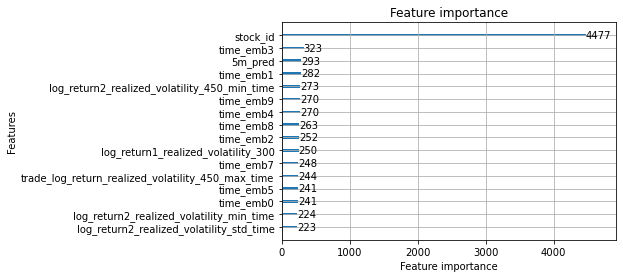

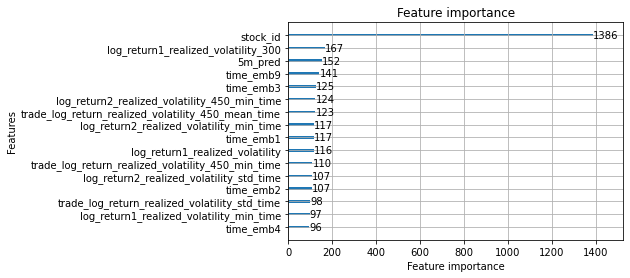

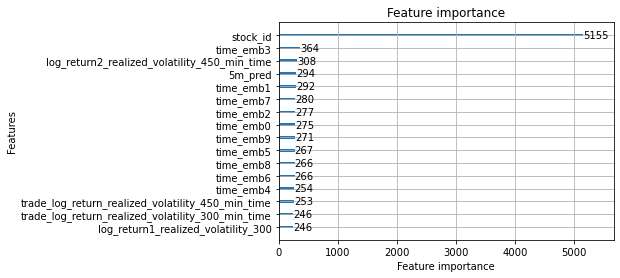

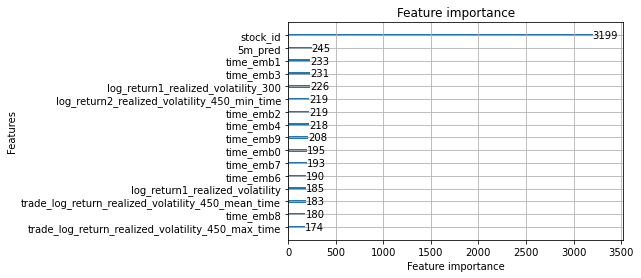

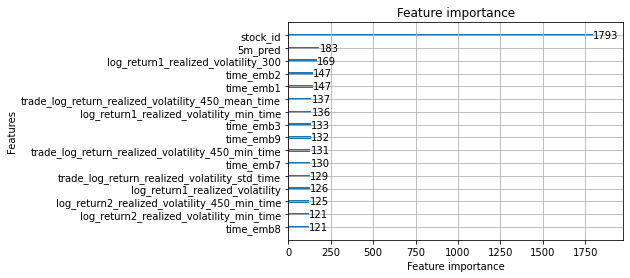

In [97]:
for m in models:
    lgb.plot_importance(m, max_num_features=16)